# Setup

In [1]:
!nvidia-smi

Sat Apr 10 15:25:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/gllmp/DenseDepth.git

Cloning into 'DenseDepth'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 294 (delta 17), reused 36 (delta 6), pack-reused 242
Receiving objects: 100% (294/294), 17.84 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [3]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

--2021-04-10 15:26:00--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.89.107
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.89.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth/nyu.h5’

./DenseDepth/nyu.h5 100%[===================>] 164.89M  20.6MB/s    in 8.9s    

2021-04-10 15:26:10 (18.5 MB/s) - ‘./DenseDepth/nyu.h5’ saved [172897376/172897376]



# Generate depth maps grid

In [ ]:
!cd DenseDepth; python test.py

/bin/bash: line 0: cd: DenseDepth: No such file or directory
Loading model...

Model loaded (nyu.h5).

Loaded (11) images of size (1024, 1024, 3).
<Figure size 1000x500 with 1 Axes>


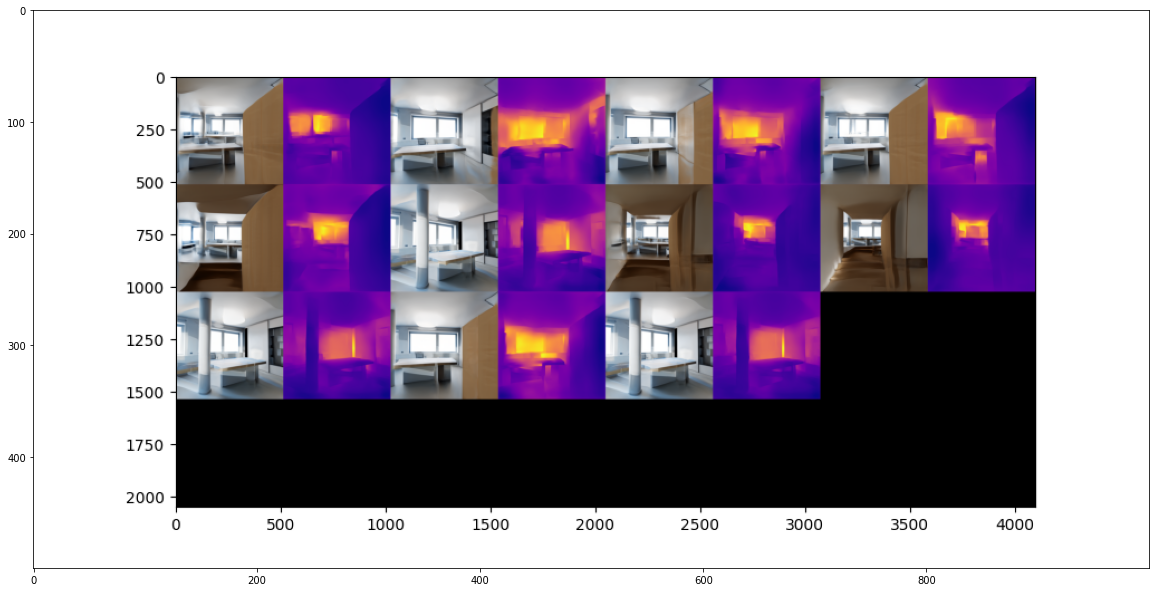

In [ ]:
from matplotlib import pyplot as plt
from skimage import io

plt.figure(figsize=(20,20))
plt.imshow( io.imread('/content/DenseDepth/test.png') )

/bin/bash: line 0: cd: DenseDepth/PyTorch: No such file or directory
python3: can't open file 'test_pytorch.py': [Errno 2] No such file or directory


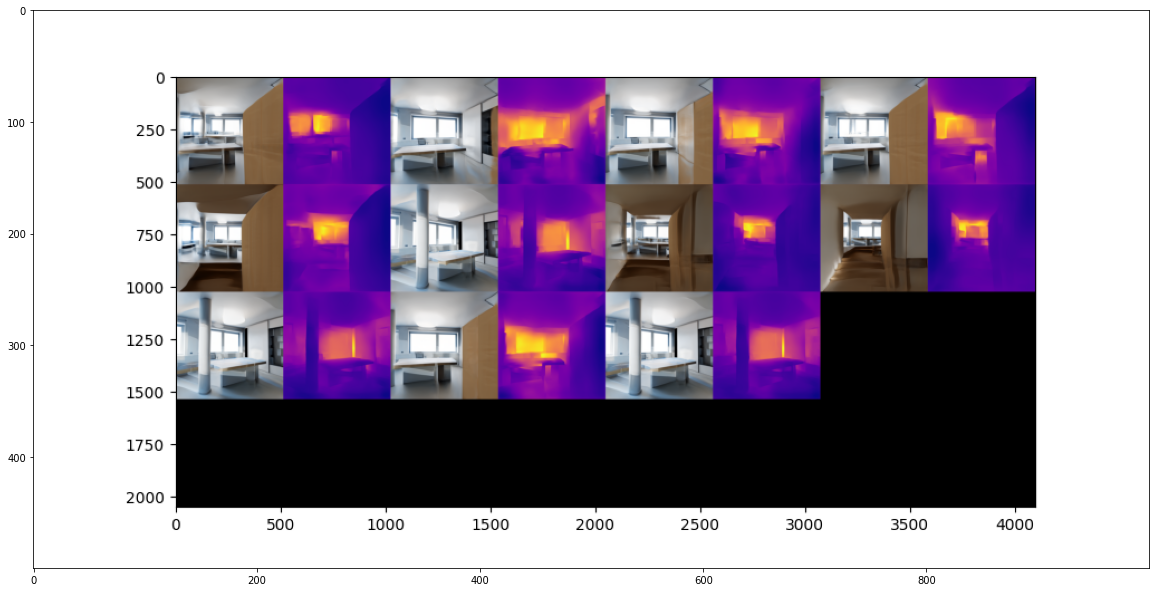

In [ ]:
!cd DenseDepth/PyTorch; python test_pytorch.py
from matplotlib import pyplot as plt
from skimage import io

plt.figure(figsize=(20,20))
plt.imshow( io.imread('/content/DenseDepth/test.png') )

# Custom scripts

Modify utils.py with the following cell for custom depth image export

In [ ]:
import os
import numpy as np
from PIL import Image

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('plasma')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    
    all_images = []
    c = 0
    
    for i in range(outputs.shape[0]):
        c += 1
        
        imgs = []
        
        if isinstance(inputs, (list, tuple, np.ndarray)):
            x = to_multichannel(inputs[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if isinstance(gt, (list, tuple, np.ndarray)):
            x = to_multichannel(gt[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(plasma(rescaled)[:,:,:3])
        else:
            imgs.append(to_multichannel(outputs[i]))
        
        out_dir = r"/content/DenseDepth/outputs"
        
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        im = Image.fromarray(np.uint8(imgs[0]*255))
        im2 = Image.fromarray(np.uint8(imgs[1]*255))

        im.save("/content/DenseDepth/outputs/img_{1}_color.png".format(out_dir, c))
        im2.save("/content/DenseDepth/outputs/img_{1}_depth.png".format(out_dir, c))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)
    
    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e


Add this cell as export_depth.py file to the DenseDepth folder

In [ ]:
# export-depth.py

import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, display_images
from matplotlib import pyplot as plt

# Argument Parser
parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
parser.add_argument('--input', default='examples/*.png', type=str, help='Input filename or folder.')
args = parser.parse_args()

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(args.model, custom_objects=custom_objects, compile=False)

#print('\nModel loaded ({0}).'.format(args.model))

# Input images
inputs = load_images( glob.glob(args.input) )
#print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

#matplotlib problem on ubuntu terminal fix
#matplotlib.use('TkAgg')   

# Display results
#viz = display_images(outputs.copy(), inputs.copy())
viz = display_images(outputs.copy(), inputs.copy(), is_colormap=False)
#plt.figure(figsize=(10,5))
#plt.imshow(viz)
#plt.savefig('test.png')
#plt.show()


# Export video frames

In [74]:
# empty examples folder
!rm -r /content/DenseDepth/examples/*

In [18]:
# empty frames folder
!rm -r /content/DenseDepth/frames/*

In [75]:
# empty outputs folder
!rm -r /content/DenseDepth/outputs/*

In [19]:
# export video frames
import os
import subprocess
from glob import glob

input_dir = "/content/DenseDepth/input"
frames_dir = "/content/DenseDepth/frames"

os.chdir("/content/DenseDepth")

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

files = glob("/content/DenseDepth/input/*")

for video in files:
  subprocess.call(["ffmpeg", "-i", video, frames_dir + "/frame_%03d.png"])

In [20]:
# split frames into subfolders
!python folder_splitter.py /content/DenseDepth/frames

## Split a list in two

In [ ]:
# split a list in two
import numpy as np

list = []
for num in range(0, 722):
  list.append(num)

def split_list(list):
  length = len(list)

  tmp1 = []
  tmp2 = []

  for el in list[:int(np.floor(length/2))]:
    tmp1.append(el)
  for el in list[int(np.ceil(length/2)):]:
    tmp2.append(el)
  
  return [tmp1, tmp2]

result = split_list(list)

# Export depth image from RGB files

In [76]:
import os
import subprocess
import numpy as np
from glob import glob
from tqdm import tqdm

os.chdir("/content/DenseDepth")

subfolders = glob("/content/DenseDepth/frames/*")
subfolders.sort()

for subfolder in tqdm(subfolders):
  subprocess.call(['python', 'export_depth.py', '--input', subfolder + "/*.png"])






  0%|          | 0/73 [00:00<?, ?it/s]




  1%|▏         | 1/73 [00:16<19:42, 16.43s/it]




  3%|▎         | 2/73 [00:32<19:24, 16.40s/it]




  4%|▍         | 3/73 [00:49<19:07, 16.39s/it]




  5%|▌         | 4/73 [01:05<18:55, 16.46s/it]




  7%|▋         | 5/73 [01:22<18:35, 16.41s/it]




  8%|▊         | 6/73 [01:38<18:18, 16.39s/it]




 10%|▉         | 7/73 [01:54<18:04, 16.44s/it]




 11%|█         | 8/73 [02:11<17:52, 16.50s/it]




 12%|█▏        | 9/73 [02:28<17:35, 16.49s/it]




 14%|█▎        | 10/73 [02:44<17:16, 16.45s/it]




 15%|█▌        | 11/73 [03:00<16:59, 16.44s/it]




 16%|█▋        | 12/73 [03:17<16:46, 16.50s/it]




 18%|█▊        | 13/73 [03:33<16:28, 16.48s/it]




 19%|█▉        | 14/73 [03:50<16:10, 16.46s/it]




 21%|██        | 15/73 [04:06<15:56, 16.49s/it]




 22%|██▏       | 16/73 [04:23<15:41, 16.51s/it]




 23%|██▎       | 17/73 [04:40<15:25, 16.53s/it]




 25%|██▍       | 18/73 [04:56<15:09, 16.53s/it]




 26%|██▌       | 19/73 [0

In [ ]:
%cd /content/DenseDepth
!python export_depth.py --input "/content/DenseDepth/frames/001/*.png"

In [ ]:
# zip depth images folder
!zip -r depth-map.zip /content/DenseDepth/outputs/

In [ ]:
# export RGB video
#!ffmpeg -framerate 24 -i /content/DenseDepth/frames/frame_%03d.png /content/rgb.mp4

In [80]:
#export depth map video
%cd /content/DenseDepth/outputs/
!ffmpeg -f image2 -pattern_type glob -framerate 24 -i '*.png' /content/depth.mp4


/content/DenseDepth/outputs
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 -

# Generate point cloud from depth map

In [ ]:
# Point cloud demo
!pip install PyGLM PySide2 pyopengl

%cd /content/DenseDepth
!python demo.py

In [ ]:
!python generate_pointcloud.py /content/DenseDepth/examples/seed0001.png /content/DenseDepth/outputs/img_2_depth.png point-cloud.ply

Traceback (most recent call last):
  File "generate_pointcloud.py", line 109, in <module>
    generate_pointcloud(args.rgb_file,args.depth_file,args.ply_file)
  File "generate_pointcloud.py", line 67, in generate_pointcloud
    raise Exception("Color and depth image do not have the same resolution.")
Exception: Color and depth image do not have the same resolution.
